# Car report analysis with GPT4-Vision & Azure AI enhancements

GPT-4 Turbo with Vision provides **exclusive access to Azure AI Services tailored enhancements**. When combined with Azure AI Vision, it enhances your chat experience by providing the chat model with more detailed information about visible text in the image and the locations of objects.

- The **Optical Character Recognition (OCR) integration** allows the model to produce higher quality responses for dense text, transformed images, and number-heavy financial documents. It also covers a wider range of languages.

- The **object grounding integration** brings a new layer to data analysis and user interaction, as the feature can visually distinguish and highlight important elements in the images it processes.

https://learn.microsoft.com/en-us/azure/ai-services/openai/gpt-v-quickstart?tabs=enhanced&pivots=rest-api

<img src="screenshot.png">

In [1]:
import base64
import datetime
import glob
import gradio as gr
import json
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image

In [2]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [3]:
check_openai_version()

Installed OpenAI version: 1.3.8
[OK] OpenAI version 1.3.8 is >= 1.0.0


In [4]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [5]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 20-Dec-2023 10:05:25


In [6]:
print(f"Python version: {sys.version}")

Python version: 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]


## Azure AI services

In [7]:
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 1.3.8


In [8]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")

# Azure AI Vision (aka Azure Computer Vision)
azure_aivision_endpoint = os.getenv("azure_aivision_endpoint")
azure_aivision_key = os.getenv("azure_aivision_key")

In [9]:
indexname = "car-reports-tests"

In [10]:
model = "GPT4Vision"  # This is the deployed name of your GPT4 Vision model from the Azure Open AI studio

## Document

In [11]:
image_file = "car_report.jpg"

!ls $image_file -lh

-rwxrwxrwx 1 root root 2.3M Dec 18 16:35 car_report.jpg


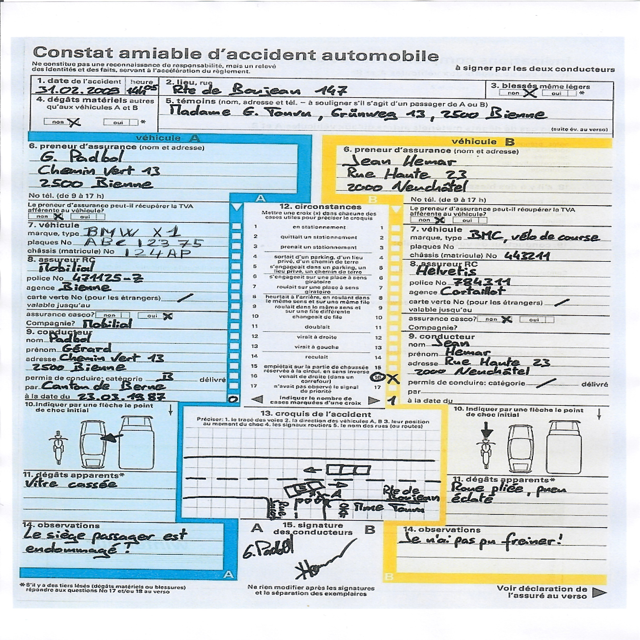

In [12]:
img = Image.open(image_file)
img.resize((640, 640))

## Function

In [15]:
def GPT4V_with_AzureAIVision(image_file, prompt):
    """
    GPT-4 Turbo with vision and Azure AI enhancements
    """
    # Testing if image file exists
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")

    # Endpoint
    base_url = f"{openai.api_base}/openai/deployments/{model}"
    gpt4vision_endpoint = (
        f"{base_url}/extensions/chat/completions?api-version=2023-12-01-preview"
    )

    # Header
    headers = {"Content-Type": "application/json", "api-key": openai.api_key}

    # Encoded image
    base_64_encoded_image = base64.b64encode(open(image_file, "rb").read()).decode(
        "ascii"
    )

    # Context
    context = """
You are an insurance AI expert. You will analyse a car report document. 
Always reply in English.
"""

    # Payload
    json_data = {
        "model": "gpt-4-vision-preview",
        "enhancements": {"ocr": {"enabled": True}, "grounding": {"enabled": True}},
        "dataSources": [
            {
                "type": "AzureComputerVision",
                "endpoint": azure_aivision_endpoint,
                "key": azure_aivision_key,
                "indexName": indexname,
            }
        ],
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": [prompt, {"image": base_64_encoded_image}]},
        ],
        "max_tokens": 4000,
        "temperature": 0.7,
        "top_p": 1,
    }

    # Response
    response = requests.post(
        gpt4vision_endpoint, headers=headers, data=json.dumps(json_data)
    )

    # Testing the status code from the model response
    if response.status_code == 200:
        now = str(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"))
        print(f"Analysis of image: {image_file}")
        results = json.loads(response.text)
        print("\033[1;31;34m")
        print(results["choices"][0]["message"]["content"])
        
        prompt_tokens = results["usage"]["prompt_tokens"]
        completion_tokens = results["usage"]["completion_tokens"]
        total_tokens = results["usage"]["total_tokens"]

        print("\n\033[1;31;32mDone:", now)
        print(f"Prompt tokens = {prompt_tokens} | Completion tokens = {completion_tokens} \
| Total tokens = {total_tokens}")
        print("\n[Note] These results are generated by an AI")
        print("\033[0m")
        
        return results
    
    elif response.status_code == 429:
        print(
            "[429 Error] Too many requests. Please wait a couple of seconds and try again.\n"
        )
        print(json.loads(response.text))

    else:
        print(f"[Error] Error code: {response.status_code}\n")
        print(json.loads(response.text))


## Analysis

In [16]:
prompt = "Classify this document into 'Driver licence', 'Passport', 'European Accident form', 'Others'"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

This document is a 'European Accident form'.

Done: 20-Dec-2023 10:10:48
Prompt tokens = 2424 | Completion tokens = 9 | Total tokens = 2433

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnpCPRfOsB1CtXCJjKSrka13hHPI',
 'object': 'chat.completion',
 'created': 1703067042,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': "This document is a 'European Accident form'."},
   'enhancements': {'grounding': {'lines': [{'text': "This document is a 'European Accident form'.",
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2424,
  'completion_tokens': 9,
  'total_tokens': 2433}}

In [17]:
prompt = "What is the language used in this document?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

The language used in this document is French.

Done: 20-Dec-2023 10:11:23
Prompt tokens = 2412 | Completion tokens = 9 | Total tokens = 2421

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnpjMqta8Q2wYhMUPbp1QGwfNO8a',
 'object': 'chat.completion',
 'created': 1703067075,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The language used in this document is French.'},
   'enhancements': {'grounding': {'lines': [{'text': 'The language used in this document is French.',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2412,
  'completion_tokens': 9,
  'total_tokens': 2421}}

In [18]:
prompt = "Generate a summary"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

The document is a European Accident Statement form filled out to report a car accident. The accident occurred on 31.02.2008 at 14:05 on Rte de Barjean 147. No injuries are reported.

Vehicle A is a BMW X1 with registration plate number ABC 12375, insured by Ry Mobilial with policy number 471125-2. Vehicle B is a BMC racing bike with chassis number 443211, insured by Felvetis with policy number 784311.

The insured of vehicle A is G. Padbol, residing at Chemin Vert 13, 2500 Bienne, and vehicle B's insured is Jean Hemar at Rue Haute 23, 2000 Neuchatel.

The circumstances indicate that neither vehicle was recovering VAT, and both vehicles had casco insurance, with vehicle A's being with Mobiliat and vehicle B's with an unspecified company.

The diagram shows that the bicycle (vehicle B) was hit from behind while both were traveling in the same direction in the same lane. The apparent damage to vehicle A is a broken window, and the passenger seat is damag

{'id': 'chatcmpl-8XnqinwfvrKfZtgIhRmLuRixMyCAI',
 'object': 'chat.completion',
 'created': 1703067136,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The document is a European Accident Statement form filled out to report a car accident. The accident occurred on 31.02.2008 at 14:05 on Rte de Barjean 147. No injuries are reported.\n\nVehicle A is a BMW X1 with registration plate number ABC 12375, insured by Ry Mobilial with policy number 471125-2. Vehicle B is a BMC racing bike with chassis number 443211, insured by Felvetis with policy number 784311.\n\nThe insured of vehicle A is G. Padbol, residing at Chemin Vert 13, 2500 Bienne, and vehicle B\'s insured is Jean Hemar at Rue Haute 23, 2000 Neuchatel.\n\nThe circumstances indicate that neither vehicle was recovering VAT, and both vehicles had casco insurance, with vehicle A\'s being with Mobiliat and vehicle B\'s with an 

In [19]:
prompt = "What are the names, cars models of vehicles A and B?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

The name of the insurance policyholder for vehicle A is G. Padbol, and the car model is a BMW X1. The name of the insurance policyholder for vehicle B is Jean Hemar, and the vehicle is a BMC racing bicycle.

Done: 20-Dec-2023 10:13:35
Prompt tokens = 2416 | Completion tokens = 50 | Total tokens = 2466

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnrqLYalrJ9R7vbA5LtPfGnnV9I5',
 'object': 'chat.completion',
 'created': 1703067206,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The name of the insurance policyholder for vehicle A is G. Padbol, and the car model is a BMW X1. The name of the insurance policyholder for vehicle B is Jean Hemar, and the vehicle is a BMC racing bicycle.'},
   'enhancements': {'grounding': {'lines': [{'text': 'The name of the insurance policyholder for vehicle A is G. Padbol, and the car model is a BMW X1. The name of the insurance policyholder for vehicle B is Jean Hemar, and the vehicle is a BMC racing bicycle.',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2416,
  'completion_tokens': 50,
  'total_tokens': 2466}}

In [29]:
prompt = "Display some informations about the brand and model of the vehicle A"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

Vehicle A is a BMW X1, which is a compact luxury crossover SUV produced by BMW. It's part of the X series of vehicles, which are known for their blend of luxury, practicality, and BMW's signature driving dynamics. The BMW X1 provides a high seating position typical of SUVs, but also maintains a sporty design and performance that BMW cars are known for. It's suitable for those who need an upscale vehicle that can handle a variety of driving conditions and provide enough space for passengers and cargo. The BMW X1 has gone through several generations, with advances in technology, design, and performance.

Done: 20-Dec-2023 10:19:54
Prompt tokens = 2415 | Completion tokens = 125 | Total tokens = 2540

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnxwXxks7nOSXDSptXtyTNYrVQXW',
 'object': 'chat.completion',
 'created': 1703067584,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': "Vehicle A is a BMW X1, which is a compact luxury crossover SUV produced by BMW. It's part of the X series of vehicles, which are known for their blend of luxury, practicality, and BMW's signature driving dynamics. The BMW X1 provides a high seating position typical of SUVs, but also maintains a sporty design and performance that BMW cars are known for. It's suitable for those who need an upscale vehicle that can handle a variety of driving conditions and provide enough space for passengers and cargo. The BMW X1 has gone through several generations, with advances in technology, design, and performance."},
   'enhancements': {'grounding': {'lines': [{'text': "Vehicle A is a BMW X1, which is a compact luxury crossover SUV produc

In [20]:
prompt = "What are the damages for vehicles A and B?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

Vehicle A has a broken window ("vitre cassée") and the passenger seat is damaged ("Le siège passager est endommagé"). For Vehicle B, the damage includes a punctured tire ("Roue plicée, pneu éclaté").

Done: 20-Dec-2023 10:14:23
Prompt tokens = 2413 | Completion tokens = 56 | Total tokens = 2469

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnsXCWmmN7wXQyrEVgol4rpVOODB',
 'object': 'chat.completion',
 'created': 1703067249,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'Vehicle A has a broken window ("vitre cassée") and the passenger seat is damaged ("Le siège passager est endommagé"). For Vehicle B, the damage includes a punctured tire ("Roue plicée, pneu éclaté").'},
   'enhancements': {'grounding': {'lines': [{'text': 'Vehicle A has a broken window ("vitre cassée") and the passenger seat is damaged ("Le siège passager est endommagé"). For Vehicle B, the damage includes a punctured tire ("Roue plicée, pneu éclaté").',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2413,
  'completion_tokens': 56,
  'total_tokens': 2469}}

In [21]:
prompt = "Do we have injured people?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

There were no injuries reported in the car accident. The section labeled "3. blessés même légers" (3. light injuries) has "non" (no) selected, indicating that there were no injured parties as a result of the incident.

Done: 20-Dec-2023 10:14:52
Prompt tokens = 2409 | Completion tokens = 51 | Total tokens = 2460

[Note] These results are generated by an AI



{'id': 'chatcmpl-8Xnt6RFr6uHiMOb5RSeYrNPri9Yto',
 'object': 'chat.completion',
 'created': 1703067284,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'There were no injuries reported in the car accident. The section labeled "3. blessés même légers" (3. light injuries) has "non" (no) selected, indicating that there were no injured parties as a result of the incident.'},
   'enhancements': {'grounding': {'lines': [{'text': 'There were no injuries reported in the car accident. The section labeled "3. blessés même légers" (3. light injuries) has "non" (no) selected, indicating that there were no injured parties as a result of the incident.',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2409,
  'completion_tokens': 51,
  'total_tokens': 2460}}

In [22]:
prompt = "Do we have some witness?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

Yes, there is a witness listed in the report. The witness is Madame G. Tourn, with the address Grünweg 13, 2500 Bienne. Her contact information is not fully visible, but it's indicated that you should underline if the witness is a passenger of vehicle A or B, which is not underlined, suggesting the witness was not a passenger in either vehicle.

Done: 20-Dec-2023 10:15:31
Prompt tokens = 2409 | Completion tokens = 80 | Total tokens = 2489

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XntgVTVnw1pcWcGrjeQF1i4xfRyJ',
 'object': 'chat.completion',
 'created': 1703067320,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': "Yes, there is a witness listed in the report. The witness is Madame G. Tourn, with the address Grünweg 13, 2500 Bienne. Her contact information is not fully visible, but it's indicated that you should underline if the witness is a passenger of vehicle A or B, which is not underlined, suggesting the witness was not a passenger in either vehicle."},
   'enhancements': {'grounding': {'lines': [{'text': "Yes, there is a witness listed in the report. The witness is Madame G. Tourn, with the address Grünweg 13, 2500 Bienne. Her contact information is not fully visible, but it's indicated that you should underline if the witness is a passenger of vehicle A or B, which is not underlined, suggesting the witness was not a passenger in 

### Let's analyse the drawings from the report

In [23]:
prompt = "What are the main colors of this document?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

The main colors in the document are white, blue, yellow, and black. There are sections with blue backgrounds, notably at the top where the title "Constat amiable d'accident automobile" is located, and also in some of the form's fields related to vehicle A and vehicle B's insurance information. The yellow color is used to highlight certain sections, such as the fields for the insurance policy number and the accident circumstances. Text and lines are primarily in black, providing contrast against the white background and colored sections. The checkboxes and the outline of the accident sketch area are in blue. The form has a structured layout with alternating white and colored fields to distinguish different sections for clarity.

Done: 20-Dec-2023 10:15:59
Prompt tokens = 2412 | Completion tokens = 138 | Total tokens = 2550

[Note] These results are generated by an AI



{'id': 'chatcmpl-8Xnu9xiorq4SPV1sVkQpuBEOjdrQE',
 'object': 'chat.completion',
 'created': 1703067349,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The main colors in the document are white, blue, yellow, and black. There are sections with blue backgrounds, notably at the top where the title "Constat amiable d\'accident automobile" is located, and also in some of the form\'s fields related to vehicle A and vehicle B\'s insurance information. The yellow color is used to highlight certain sections, such as the fields for the insurance policy number and the accident circumstances. Text and lines are primarily in black, providing contrast against the white background and colored sections. The checkboxes and the outline of the accident sketch area are in blue. The form has a structured layout with alternating white and colored fields to distinguish different sections for clar

In [24]:
prompt = "Do we have some handwritten text?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

Yes, the image contains handwritten text. There are several sections of the document filled out with handwriting, providing details such as names, addresses, telephone numbers, vehicle information, insurance details, circumstances of the accident, damages, and observations. There are also handwritten signatures at the bottom of the document.

Done: 20-Dec-2023 10:16:34
Prompt tokens = 2410 | Completion tokens = 59 | Total tokens = 2469

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnujVXc9aQ3gJrXcuMV0ETTNmA4x',
 'object': 'chat.completion',
 'created': 1703067385,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'Yes, the image contains handwritten text. There are several sections of the document filled out with handwriting, providing details such as names, addresses, telephone numbers, vehicle information, insurance details, circumstances of the accident, damages, and observations. There are also handwritten signatures at the bottom of the document.'},
   'enhancements': {'grounding': {'lines': [{'text': 'Yes, the image contains handwritten text. There are several sections of the document filled out with handwriting, providing details such as names, addresses, telephone numbers, vehicle information, insurance details, circumstances of the accident, damages, and observations. There are also handwritten signatures at the bottom of the 

In [25]:
prompt = "Explain the drawings from section number 10 for vehicles A and B"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

In section number 10, the drawings depict the initial point of contact between vehicle A and vehicle B. 

For vehicle A, which is a BMW X1, the arrow is pointing to the rear left side, indicating that this is where the initial impact occurred. 

For vehicle B, which is a BMC racing bicycle, the arrow points to the front right side, suggesting that the bicycle hit vehicle A on its front right side. 

These drawings help to visualize the point of impact and the position of the vehicles relative to each other at the moment of the accident.

Done: 20-Dec-2023 10:17:21
Prompt tokens = 2417 | Completion tokens = 114 | Total tokens = 2531

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnvA7gOWkO1RGk6LJL3LnNu0rIFC',
 'object': 'chat.completion',
 'created': 1703067412,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'In section number 10, the drawings depict the initial point of contact between vehicle A and vehicle B. \n\nFor vehicle A, which is a BMW X1, the arrow is pointing to the rear left side, indicating that this is where the initial impact occurred. \n\nFor vehicle B, which is a BMC racing bicycle, the arrow points to the front right side, suggesting that the bicycle hit vehicle A on its front right side. \n\nThese drawings help to visualize the point of impact and the position of the vehicles relative to each other at the moment of the accident.'},
   'enhancements': {'grounding': {'lines': [{'text': 'In section number 10, the drawings depict the initial point of contact between vehicle A and vehicle B. \n\nFor vehicle A, which 

In [26]:
prompt = "Explain the drawing from section number 13"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

The drawing in section number 13 of the car report document depicts the scenario of a traffic accident. It shows the layout of the roads, the direction of the vehicles involved in the accident, and their positions at the moment of impact.

From the sketch, we can observe:

- A two-way street with a dashed center line, indicating traffic flows in opposite directions.
- Vehicle A, which seems to be a BMW X1, is represented on the left side of the drawing, facing downwards towards an intersection or junction point.
- Vehicle B, identified as a BMC racing bicycle, is depicted on the right side of the drawing, facing upwards, suggesting it was coming from the opposite direction of Vehicle A.
- The point of initial impact is marked with arrows on both vehicles, indicating a head-on collision. The arrow on Vehicle A points to the front right side, while the arrow on Vehicle B points to the front left side of the bicycle.
- The names of the roads are written 

{'id': 'chatcmpl-8Xnvw28FFSrmAX6yAdwpG2J4vwIct',
 'object': 'chat.completion',
 'created': 1703067460,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The drawing in section number 13 of the car report document depicts the scenario of a traffic accident. It shows the layout of the roads, the direction of the vehicles involved in the accident, and their positions at the moment of impact.\n\nFrom the sketch, we can observe:\n\n- A two-way street with a dashed center line, indicating traffic flows in opposite directions.\n- Vehicle A, which seems to be a BMW X1, is represented on the left side of the drawing, facing downwards towards an intersection or junction point.\n- Vehicle B, identified as a BMC racing bicycle, is depicted on the right side of the drawing, facing upwards, suggesting it was coming from the opposite direction of Vehicle A.\n- The point of initial impact is

In [27]:
prompt = "What are the comments in section 14 for vehicles A and B?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

The comments in section 14 for vehicle A are "Le siège passager est endommagé" which translates to "The passenger seat is damaged."

For vehicle B, the comments in section 14 are "Je n'ai pas pu freiner!" which translates to "I couldn't brake!"

Done: 20-Dec-2023 10:18:33
Prompt tokens = 2417 | Completion tokens = 61 | Total tokens = 2478

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnwW0gsaitwUKuUCsco6sgGBnuf4',
 'object': 'chat.completion',
 'created': 1703067496,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The comments in section 14 for vehicle A are "Le siège passager est endommagé" which translates to "The passenger seat is damaged."\n\nFor vehicle B, the comments in section 14 are "Je n\'ai pas pu freiner!" which translates to "I couldn\'t brake!"'},
   'enhancements': {'grounding': {'lines': [{'text': 'The comments in section 14 for vehicle A are "Le siège passager est endommagé" which translates to "The passenger seat is damaged."\n\nFor vehicle B, the comments in section 14 are "Je n\'ai pas pu freiner!" which translates to "I couldn\'t brake!"',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2417,
  'completion_tokens': 61,
  'total_tokens': 2478}}

In [28]:
prompt = "How many signatures do we have at the end of the document?"

GPT4V_with_AzureAIVision(image_file, prompt)

Analysis of image: car_report.jpg

There are two signatures at the end of the document.

Done: 20-Dec-2023 10:19:23
Prompt tokens = 2416 | Completion tokens = 11 | Total tokens = 2427

[Note] These results are generated by an AI



{'id': 'chatcmpl-8XnxVFCRia9xzpYOW25ZbE0E8hHYZ',
 'object': 'chat.completion',
 'created': 1703067557,
 'model': 'gpt-4',
 'choices': [{'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'},
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'There are two signatures at the end of the document.'},
   'enhancements': {'grounding': {'lines': [{'text': 'There are two signatures at the end of the document.',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 2416,
  'completion_tokens': 11,
  'total_tokens': 2427}}

## Gradio webapp

In [30]:
def car_report_webapp_fn(pil_image):
    """
    Function for the Gradio webapp
    Input: pil image (pil format)
    output: results (string)
    """
    # Endpoint
    base_url = f"{openai.api_base}/openai/deployments/{model}"
    gpt4vision_endpoint = (
        f"{base_url}/extensions/chat/completions?api-version=2023-12-01-preview"
    )

    # Header
    headers = {"Content-Type": "application/json", "api-key": openai.api_key}

    # Encoded image
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    base_64_encoded_image = base64.b64encode(buffered.getvalue()).decode("ascii")

    # Context
    context = """You are an insurance AI expert. You will analyse a car report document. \
Always reply in English.
"""
    # Full prompt
    prompt = """
You respond with your analysis of the following fields:

1. Summary: Create a summary of this car report.
2. Names: What are the names of owners of vehicle A and B? \
Just answer like vehicle A = 'SMITH', Vehicle B = 'JOHNSON'
3. Vehicles: What is the brand and model of vehicle A and B? \
Just answer like vehicle A = 'AUDI', Vehicle B = 'MERCEDES'
4. Date and time: What is the date and time of the accident? \
Just answer like '01-jan-2023 22:00'
5. Address: What is the address of the accident? \
Just answer like '78 Avenue de Paris 75012 Paris'
6. Damage: Share some information about the damage.
Others damage: Display some information about material damage other than to vehicles A and B.
7. Injured people: Do we have injured people?
8. Section 14 comments: What are the comments in section 14?
9. Damage classification: Classify this damage as LIGHT DAMAGE, MEDIUM DAMAGE, SEVERE DAMAGE.
10. Drawings #10: Explain the drawings from section number 10 for vehicles A and B?
11. Drawing #13: Explain the drawing from section number 13?
12. Signatures: Do we have two signatures at the end of this document? \
Just answer like "Two signatures detected", "One signature detected", "No signature detected"
"""
    # Payload
    json_data = {
        "model": "gpt-4-vision-preview",
        "enhancements": {"ocr": {"enabled": True}, "grounding": {"enabled": True}},
        "dataSources": [
            {
                "type": "AzureComputerVision",
                "endpoint": azure_aivision_endpoint,
                "key": azure_aivision_key,
                "indexName": indexname,
            }
        ],
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": [prompt, {"image": base_64_encoded_image}]},
        ],
        "max_tokens": 4000,
        "temperature": 0.7,
        "top_p": 1,
    }

    # Results
    response = requests.post(
        gpt4vision_endpoint, headers=headers, data=json.dumps(json_data)
    )

    # Testing status code
    if response.status_code == 200:
        results = json.loads(response.text)
        print(results)
        
        res = results["choices"][0]["message"]["content"]
        summary = res.split("2. Names:")[0].replace("\n", "")
        sub1 = "2. Names:"
        res2 = sub1 + res.split(sub1)[1]
        sub2 = "10. Drawings #10:"
        insights = res2.split(sub2)[0]
        drawings = sub2 + res2.split(sub2)[1]
        return summary, insights, drawings

    elif response.status_code == 429:
        print(
            "[429 Error] Too many requests. Please wait a couple of seconds and try again."
        )
        print(json.loads(response.text))

    else:
        print("[Error] Error code:", response.status_code)
        print(json.loads(response.text))

In [31]:
image_url = "https://cdn4.iconfinder.com/data/icons/lined-car-accident/48/a-03-1024.png"
logo = "<center> <img src= {} width=70px></center>".format(image_url)
title = "Your car report Copilot - Azure Open AI GPT4 Turbo Vision with Azure AI enhancements"

inputs = gr.Image(type="pil", label="Your car report document").style(height=640)
outputs = [
    gr.Text(label="Car report summary"),
    gr.Text(label="Car report insights"),
    gr.Text(label="Car report drawings analysis")
]

example = glob.glob("car_report.jpg")
theme = "gradio/soft"  # https://huggingface.co/spaces/gradio/theme-gallery

car_report_webapp = gr.Interface(
    fn=car_report_webapp_fn,
    inputs=inputs,
    outputs=outputs,
    description=logo,
    title=title,
    examples=example,
    theme=theme,
)

car_report_webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://c06c545caee778010a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
